## Process Total Precipitation

In this notebook, previously prepared monthly total precipitation data is further processed to retrieve yearly and spatially aggregated mean values. The following steps are included:
- Use monthly summed ERA5-Land data that has been cropped to Germany
- Calculate yearly mean values of monthly precipitation sums for each pixel
- Spatially aggregate precipitation for each federal state to retrieve mean value per state and year

In [1]:
# import libraries
import os
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import rasterio
import odc.stac
import pathlib
from pathlib import Path
import warnings

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# loop over years to calculate yearly mean values per pixel

for year in range(1981, 2025):

    # get file of according year
    directory = "./Climate/Precipitation/Monthly"
    files = glob.glob(os.path.join(directory, f"*{year}*.nc"))

    # glob returns a list, we only want the string with the filepath
    file = str(files[0])

    # open netCDF dataset of corresponding year with all monthly datasets
    tp = xr.open_dataset(file, decode_coords="all", decode_times=True, engine = "netcdf4")
        
    # calculate yearly mean values
    tp_year_mean = tp.resample(time="1YS", skipna=True).mean("time")

    # change unit in variable attributes
    tp_year_mean.tp.attrs["units"] = "yearly mean mm/month"

    # compress data to reduce size
    comp = dict(zlib=True, complevel=4)
    tp_year_mean.tp.encoding.update(comp)

    # save created dataset as netCDF4 files
    tp_year_mean.to_netcdf(f"./Climate/Precipitation/Yearly/tp_year_mean_{year}_GER.nc")

In [5]:
# look at exemplary dataset to get an overview
tp_year_mean

<xarray.Dataset> Size: 67kB
Dimensions:      (time: 1, lat: 83, lon: 98)
Coordinates:
  * lat          (lat) float64 664B 55.2 55.1 55.0 54.9 ... 47.3 47.2 47.1 47.0
  * lon          (lon) float64 784B 5.45 5.55 5.65 5.75 ... 14.95 15.05 15.15
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    tp           (time, lat, lon) float64 65kB nan nan nan nan ... nan nan nan

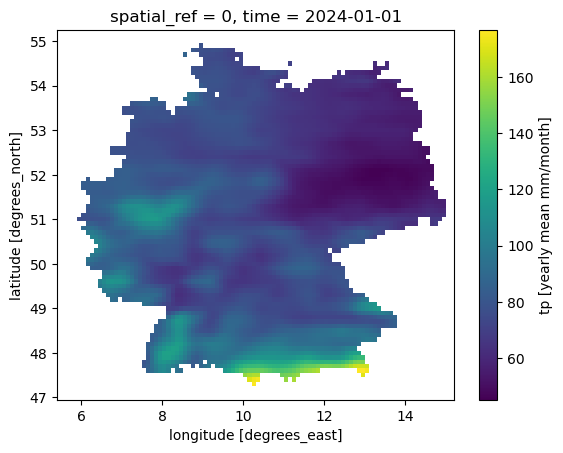

In [6]:
tp_year_mean.tp.plot()

In [7]:
# spatially aggregate yearly data
# to get mean values for Germany and federal states

In [8]:
# load all yearly tp values as one dataset
directory = f"./Climate/Precipitation/Yearly"
filelist = glob.glob(os.path.join(directory, "*.nc"))
tp_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [9]:
# calculate mean values per year for Germany
tp_yearly_spatial_means = tp_yearly.mean(['lon','lat'], skipna=True).to_dataframe()
tp_yearly_spatial_means

,tp,spatial_ref
time,,
1981-01-01,89.784582,0
1982-01-01,66.315816,0
1983-01-01,72.539045,0
1984-01-01,75.727428,0
1985-01-01,70.522082,0
1986-01-01,79.074667,0
1987-01-01,81.148595,0
1988-01-01,80.207120,0
1989-01-01,64.156950,0


In [10]:
# drop unneeded columns
tp_yearly_spatial_means = tp_yearly_spatial_means.drop(['spatial_ref'], axis=1)

In [11]:
# rename column with precipitation value to show area
tp_yearly_spatial_means.rename({"tp":"GER"}, axis=1, inplace=True)

In [12]:
# now, calculate yearly mean values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    tp_ex = tp_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=tp_ex.odc.geobox.shape,
                                                transform=tp_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly data
    tp_state = tp_yearly["tp"].where(~state_mask)

    # calculate yearly mean value of state and extract to dataframe
    tp_state_spatial_means = tp_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    tp_state_spatial_means = tp_state_spatial_means.drop(['spatial_ref'], axis=1)

    # add yearly mean values of state to dataframe
    tp_yearly_spatial_means[state] = tp_state_spatial_means["tp"]   

In [ ]:
tp_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,89.784582,72.075609,69.720739,112.006742,105.020079,77.290622,89.226193,76.015623,71.689940,80.391804,97.301651,90.181611,76.188994,103.098042,91.708728,72.124465,86.132695
1982-01-01,66.315816,42.931830,43.941366,98.499426,82.700340,62.465144,66.774637,60.532426,48.746634,60.582716,71.233385,70.344021,61.953063,79.598394,49.743802,43.757132,52.994630
1983-01-01,72.539045,56.750290,56.854644,95.142494,84.623463,68.837410,68.364857,67.763908,59.800268,67.879587,77.299383,71.428793,68.166796,87.274499,68.212958,55.484101,63.704529
1984-01-01,75.727428,56.225444,55.107884,93.307786,83.190078,73.387578,80.250217,69.767537,59.571135,73.472335,88.393487,82.525039,69.141470,93.053526,64.282590,59.527231,72.986477
1985-01-01,70.522082,56.305262,53.693119,83.475935,83.025448,71.055621,67.079426,71.286988,61.164144,69.086647,79.542272,63.410262,68.985271,67.698501,65.411526,54.111753,59.187316
1986-01-01,79.074667,65.159214,63.721070,103.967535,90.459132,69.341744,78.277286,66.751763,62.211284,71.416113,83.631470,79.600150,66.702334,96.093370,76.650365,64.050027,77.538625
1987-01-01,81.148595,65.537856,63.188621,99.903287,95.959492,76.472245,77.374637,72.950662,64.469890,76.990348,88.091141,79.167443,69.156481,89.689575,79.938660,64.154433,73.969673
1988-01-01,80.207120,57.360199,55.071194,106.306696,100.076165,76.141013,73.565745,73.030794,61.939996,74.728954,84.755314,75.260105,74.946756,91.990748,75.080313,59.925514,70.422007
1989-01-01,64.156950,45.008600,44.444653,78.785550,80.228494,64.236797,62.721104,62.036295,45.513782,60.504941,68.694960,66.878168,59.053049,75.721990,61.773304,46.440598,59.349703


In [14]:
# save as csv dataset
tp_yearly_spatial_means.to_csv("./Tables/Spatial_Means/Precipitation_Yearly_Spatial_Means_GER.csv")